# Single Star - Spectroscopic Observables

This notebook shows how you can use the `SingleStarModel` to infer stellar parameters with spectroscopic observables effective temperature, surface gravity, and metallicity (`Teff`, `log_g`, `M_H`).

Firstly, import packages.

In [1]:
import os
import numpy as np
import pandas as pd
import numpyro
import arviz as az
import matplotlib.pyplot as plt

from pprint import pprint
from corner import corner
from jax import random, vmap
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

num_chains = 10
# numpyro.enable_x64()
numpyro.set_host_device_count(num_chains)
# numpyro.set_platform("gpu")

Then, import the `SingleStarModel` from `celestify`.

In [2]:
from celestify.numpyro_models import SingleStarModel

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Truths

Let's synthesis some true parameters for our star from the `SingleStarModel` prior.

In [8]:
directory = "/mnt/data-storage/alexlyttle/scalable-stellar-inference"
filename = "truths-nearest-neighbour-clean.csv"
truths = pd.read_csv(os.path.join(directory, filename), index_col=0)
truths.head()

,track,star,mass,Y,Zinit,a_MLT,fov_core,fov_shell,star_age,R,...,evol,bol_mag,abs_G,abs_BP,abs_RP,L,log_age,age,log_numax,numax
5135942,4716,64,1.21899,0.255556,0.004416,1.789752,0.000315,0.006041,2.053233e+09,1.370623,...,0.097247,3.095263,3.064094,3.207612,2.798840,4.590869,0.312438,2.053233,3.253615,1793.142919
1047516,572,114,1.18823,0.256612,0.003238,2.030292,0.000000,0.006041,2.775791e+09,1.465378,...,0.169591,2.839847,2.821199,2.948562,2.583362,5.808464,0.443387,2.775791,3.178939,1509.868130
2374686,2422,832,1.86401,0.255684,0.004760,2.040546,0.014332,0.006041,9.790699e+08,5.314918,...,0.368276,0.849395,0.779131,1.029182,0.371158,36.328047,-0.009186,0.979070,2.295757,197.586545
4145653,6183,102,0.94165,0.278359,0.022493,1.983209,0.000000,0.006041,9.238255e+09,0.968621,...,0.105998,5.050013,4.977653,5.352141,4.440660,0.758569,0.965590,9.238255,3.503079,3184.777124
3861544,1731,120,1.15933,0.285274,0.023931,1.880585,0.000000,0.006041,5.699361e+09,1.477156,...,0.142149,3.812396,3.704555,4.010748,3.236899,2.371601,0.755826,5.699361,3.210789,1624.759176


In [9]:
star = 0
truths = truths.iloc[star].to_dict()
pprint(truths)

{'Dnu': 86.45678922314983,
 'L': 4.590869478959248,
 'M_H': -0.481894676760481,
 'R': 1.3706232965183494,
 'Teff': 7216.743375395781,
 'Y': 0.25555603,
 'Zinit': 0.00441603,
 'a_MLT': 1.789752,
 'abs_BP': 3.207611707015457,
 'abs_G': 3.064093865975688,
 'abs_RP': 2.798839650366459,
 'age': 2.0532325791993475,
 'bol_mag': 3.095262635746433,
 'center_h1': 0.2106981316935156,
 'delta_Pg': 0.0,
 'delta_X': 0.5293298083064844,
 'eps_o': 0.730985634763644,
 'evol': 0.0972471567849206,
 'f_nuc': 1.000191611775089,
 'fov_core': 0.000315,
 'fov_shell': 0.006041,
 'kron': 3869355244.083576,
 'log_Dnu': 1.9367991029468703,
 'log_L': 0.6618949457014269,
 'log_LHe': -35.84540216060529,
 'log_Lnuc': 0.6619781536664575,
 'log_R': 0.1369181092582488,
 'log_Teff': 3.8583412622284814,
 'log_Zinit': -2.354967984918757,
 'log_age': 0.3124381467119708,
 'log_g': 4.250231551679314,
 'log_kron': 9.58763860396854,
 'log_mass': 0.0860001428926783,
 'log_numax': 3.2536149056562813,
 'log_star_age': 9.3124381467

In [10]:
filename = "observables.csv"
obs = pd.read_csv(os.path.join(directory, filename), index_col=0)
obs = obs.iloc[star].to_dict()
pprint(obs)

{'M_H': -0.4433825612068176,
 'log_Dnu': 1.9366499185562132,
 'log_L': 0.660382866859436,
 'log_Teff': 3.857899427413941,
 'sigma_M_H': 0.1,
 'sigma_log_Dnu': 0.0010046509610305,
 'sigma_log_L': 0.0043429448190325,
 'sigma_log_Teff': 0.0045134050704633}


## Model

Now, let's create our star model. We need to provide some model constants. These are typically shape parameters for prior distributions. You can see the full `dict` of constants in the `model.const` attribute.

In [11]:
rng = random.PRNGKey(0)
observables = ["log_Teff", "log_L"]

# Create dictionary of model constants
const = {
    "M_H": dict(loc=obs["M_H"], scale=obs["sigma_M_H"]),
}

# Create model
model = SingleStarModel(observables, const=const)

pprint(model.const)  # check all constants

{'M_H': {'loc': -0.4433825612068176, 'scale': 0.1},
 'Y': {'high': 0.32, 'low': 0.22},
 'a_MLT': {'high': 2.7, 'low': 1.3},
 'delta': {'cov': Array([[ 2.4832934e-06, -1.6009393e-07,  3.4875325e-07, -4.1736504e-07],
       [-1.6009393e-07,  8.6322120e-07, -5.9269905e-07,  8.1550581e-07],
       [ 3.4875325e-07, -5.9269905e-07,  2.2504696e-06, -2.6773737e-06],
       [-4.1736504e-07,  8.1550581e-07, -2.6773737e-06,  4.2843349e-06]],      dtype=float32),
           'df': Array(4.1847343, dtype=float32, weak_type=True),
           'loc': Array([ 5.5830297e-04,  1.0563867e-04, -5.0787232e-05,  3.2589462e-04],      dtype=float32)},
 'log_evol': {'high': 0.0, 'loc': -0.7, 'scale': 0.4},
 'log_mass': {'high': 0.36172783601759284,
              'loc': 0.0,
              'low': -0.1549019599857432,
              'scale': 0.3}}


## Prior Predictive

Sample from the model prior.

In [12]:
rng, key = random.split(rng)
prior_predictive = Predictive(model, num_samples=10000)
prior = prior_predictive(key)
y = prior.pop("y")
for i, key in enumerate(model.outputs):
    prior[key] = y[..., i]

Let's put the prior samples in an `arviz.InferenceData` class. This makes it easier to plot and save.

In [13]:
data = az.from_numpyro(prior=prior)
data

Inference data with groups:
	> prior

We can plot the prior and overlay the true values with the `corner` package.

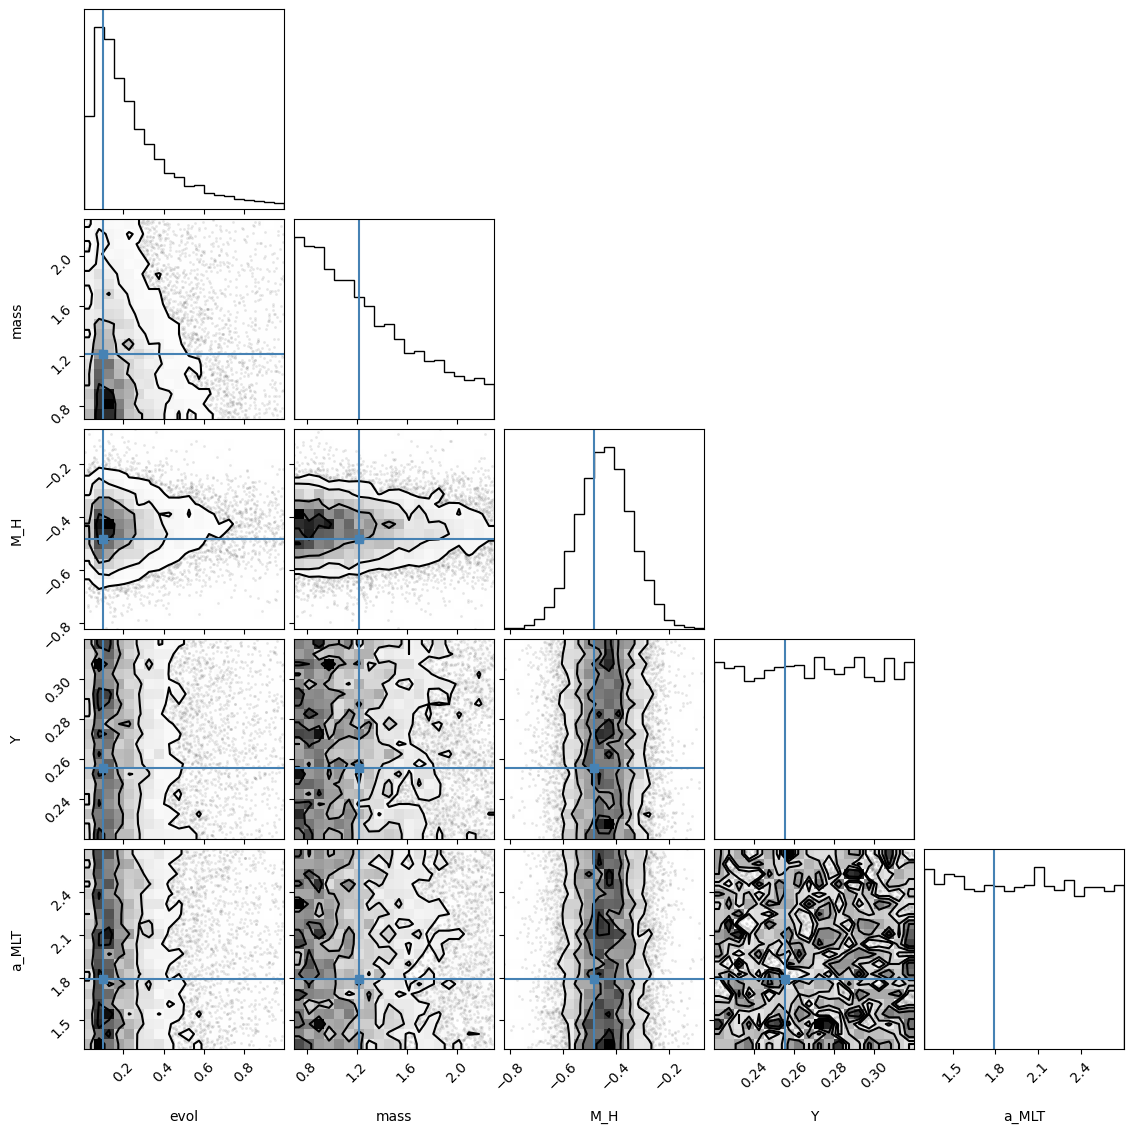

In [14]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
fig = corner(data, group="prior", var_names=var_names, truths=truths)

Let's also look at some determinisitc parameters in the model.

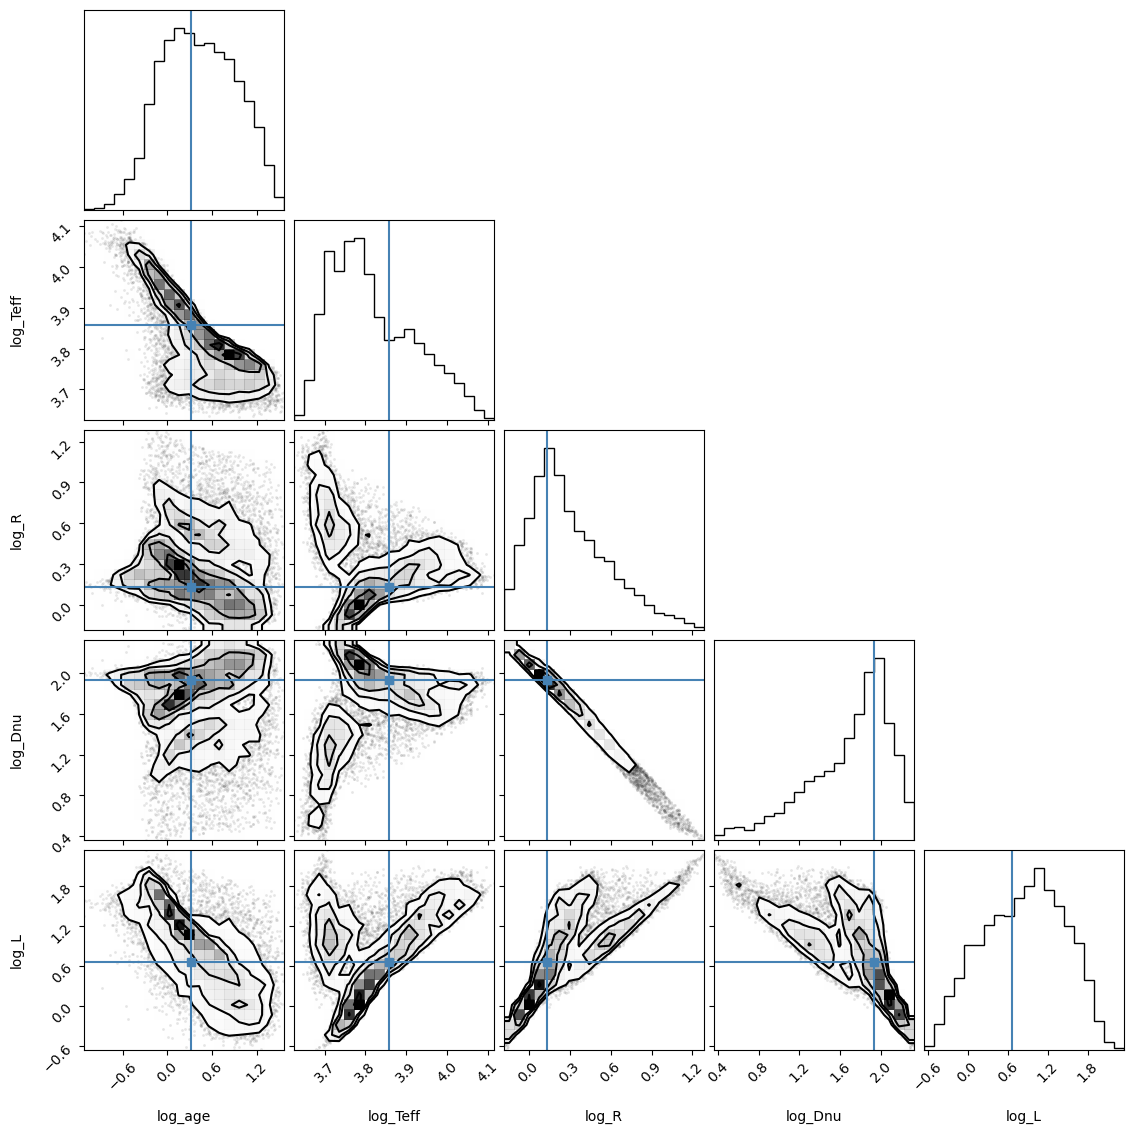

In [15]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
fig = corner(data, group="prior", var_names=var_names, truths=truths)

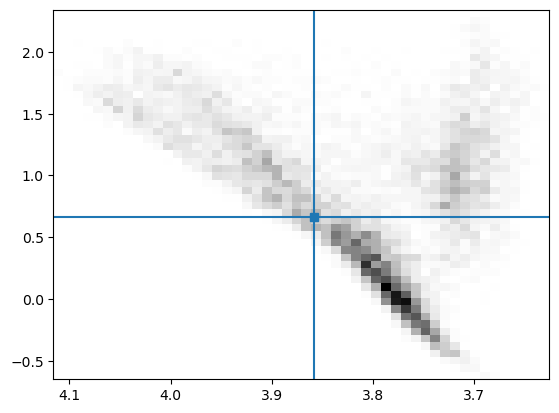

In [16]:
fig, ax = plt.subplots()

ax.hist2d(
    data.prior.log_Teff.squeeze(),
    data.prior.log_L.squeeze(),
    bins=50,
    cmap="Greys"
)
ax.axvline(truths["log_Teff"])
ax.axhline(truths["log_L"])
ax.plot(truths["log_Teff"], truths["log_L"], "s")
ax.invert_xaxis()

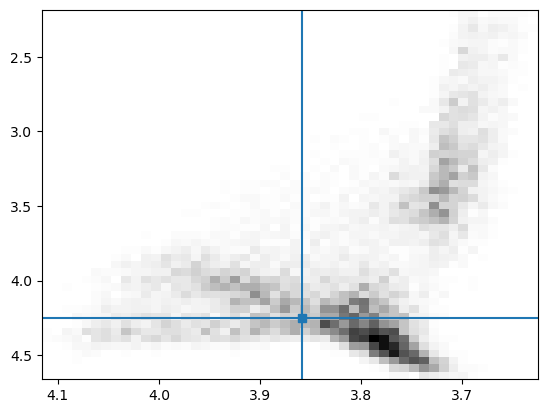

In [17]:
fig, ax = plt.subplots()

ax.hist2d(
    data.prior.log_Teff.squeeze(),
    data.prior.log_g.squeeze(),
    bins=50,
    cmap="Greys"
)
ax.axvline(truths["log_Teff"])
ax.axhline(truths["log_g"])
ax.plot(truths["log_Teff"], truths["log_g"], "s")
ax.invert_xaxis()
ax.invert_yaxis()

## Observation

In [18]:
y = np.stack([obs[key] for key in observables], axis=-1)
diag = np.stack([obs[f"sigma_{key}"] for key in observables], axis=-1)**2
print(y)
print(diag)

[3.85789943 0.66038287]
[2.03708253e-05 1.88611697e-05]


## Sampling

Let's use the No U-Turn Sampler (NUTS) as our Markov Chain Monte Carlo (MCMC) sampling algorithm.

In [19]:
num_warmup, num_samples = 1000, 1000

sampler = NUTS(model, target_accept_prob=0.8)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

Let's run the MCMC and print a summary of results.

In [20]:
rng, key = random.split(rng)
mcmc.run(key, obs=y, diag=diag)
mcmc.print_summary()

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
               M_H     -0.45      0.09     -0.45     -0.60     -0.29   3948.51      1.00
                 Y      0.27      0.03      0.27      0.23      0.32   2804.85      1.00
             a_MLT      2.01      0.41      2.01      1.44      2.70   5097.99      1.00
          log_evol     -1.00      0.15     -0.98     -1.22     -0.77   2447.57      1.00
          log_mass      0.08      0.03      0.08      0.03      0.12   2299.66      1.00
  scaled_precision      1.00      0.69      0.84      0.09      1.99   6544.10      1.00

Number of divergences: 0


Looks pretty good. We want `r_hat` to be close to 1.0 (e.g. less than 1.1). We also want the number of divergances to be very small.

Let's update our `InferenceData`.

In [21]:
posterior = mcmc.get_samples()

rng, key = random.split(rng)
posterior_predictive = Predictive(model, posterior_samples=posterior, parallel=True, return_sites=["y"])
y = posterior_predictive(key)["y"]

for i, key in enumerate(model.outputs):
    posterior[key] = y[..., i]

posterior = {k: v.reshape((num_chains, num_samples, -1)).squeeze() for k, v in posterior.items()}

In [22]:
data += az.from_dict(posterior)
data

Inference data with groups:
	> posterior
	> prior

With `arviz`, we can create a summary of the data.

In [23]:
az.summary(data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
M_H,-0.447,0.093,-0.623,-0.275,0.001,0.001,3973.0,4694.0,1.0
Y,0.272,0.029,0.227,0.320,0.001,0.000,2932.0,4632.0,1.0
a_MLT,2.012,0.415,1.385,2.700,0.006,0.004,4961.0,4899.0,1.0
evol,0.107,0.033,0.048,0.168,0.001,0.000,2516.0,3719.0,1.0
log_evol,-0.995,0.146,-1.269,-0.741,0.003,0.002,2516.0,3719.0,1.0
log_mass,0.076,0.027,0.027,0.126,0.001,0.000,2349.0,3771.0,1.0
mass,1.195,0.076,1.062,1.333,0.002,0.001,2349.0,3771.0,1.0
scaled_precision,0.996,0.687,0.036,2.238,0.008,0.006,5271.0,4196.0,1.0
log_age,0.304,0.125,0.059,0.512,0.002,0.002,2827.0,3933.0,1.0
log_Teff,3.858,0.005,3.849,3.867,0.000,0.000,10044.0,7794.0,1.0


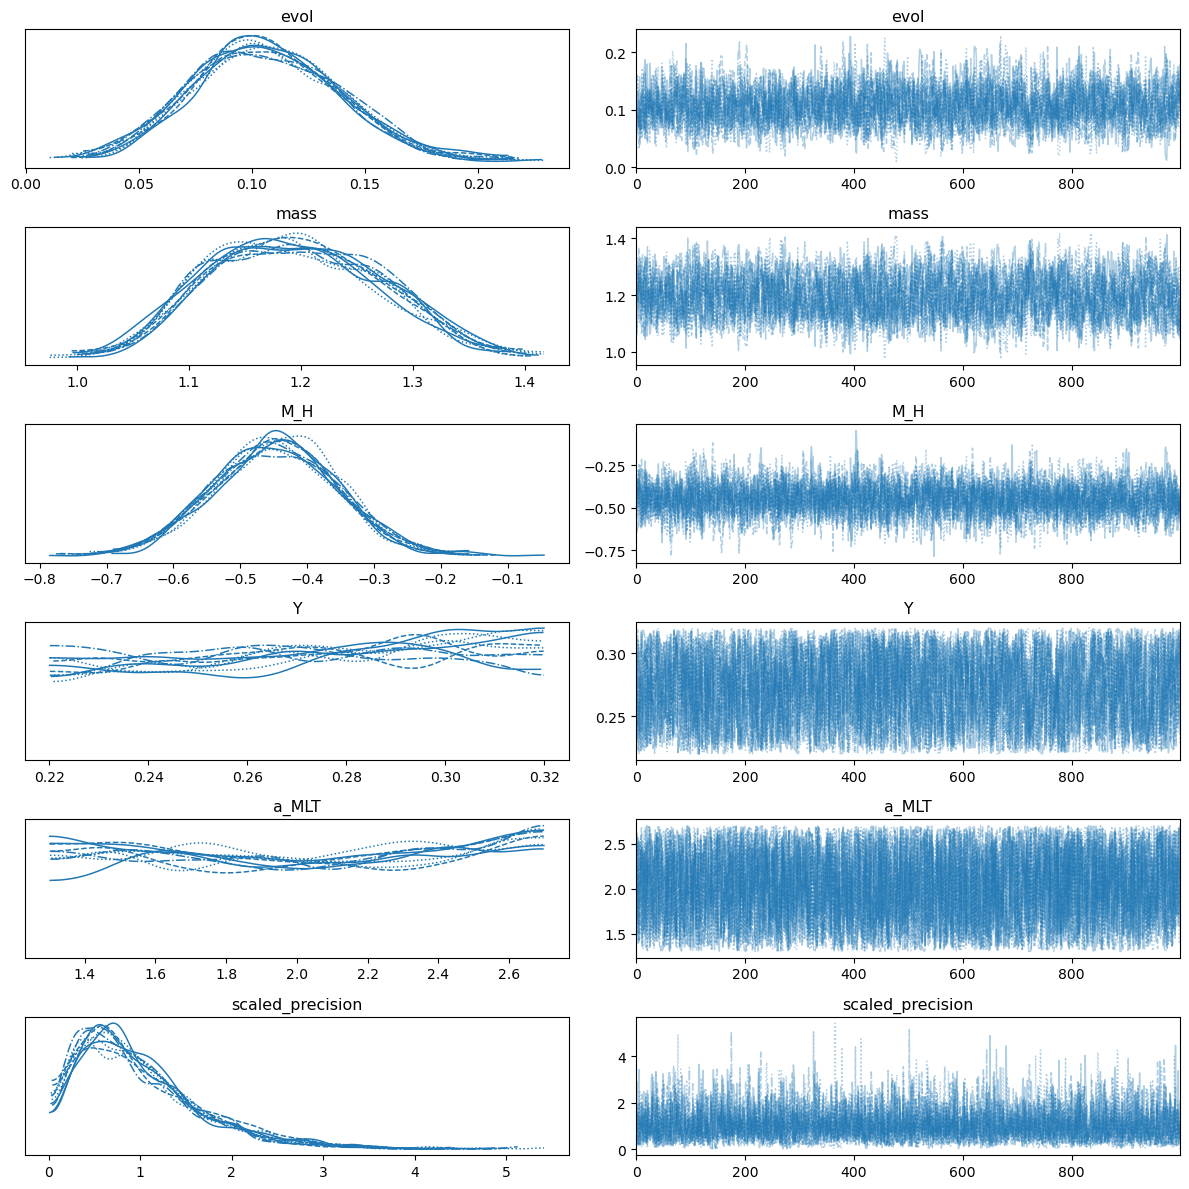

In [24]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT", "scaled_precision"]
az.plot_trace(data, var_names=var_names)
plt.tight_layout()

## Posterior Predictive

Let's check the joint posterior distributions and compare with the truth values.

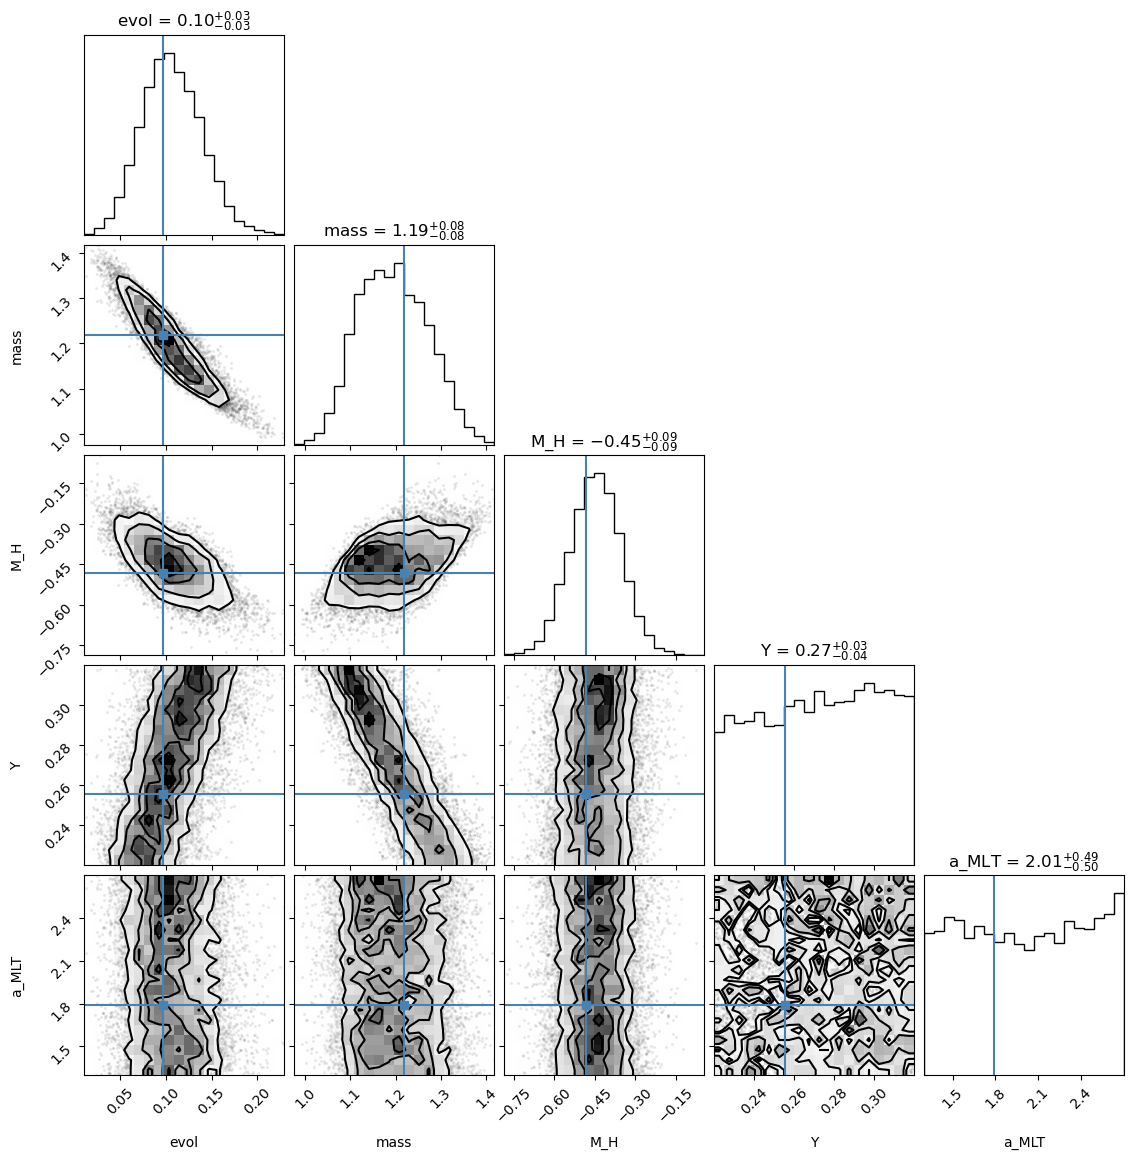

In [25]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
fig = corner(data, group="posterior", var_names=var_names, truths=truths, show_titles=True, divergences=True)

What do we predict for some deterministics?

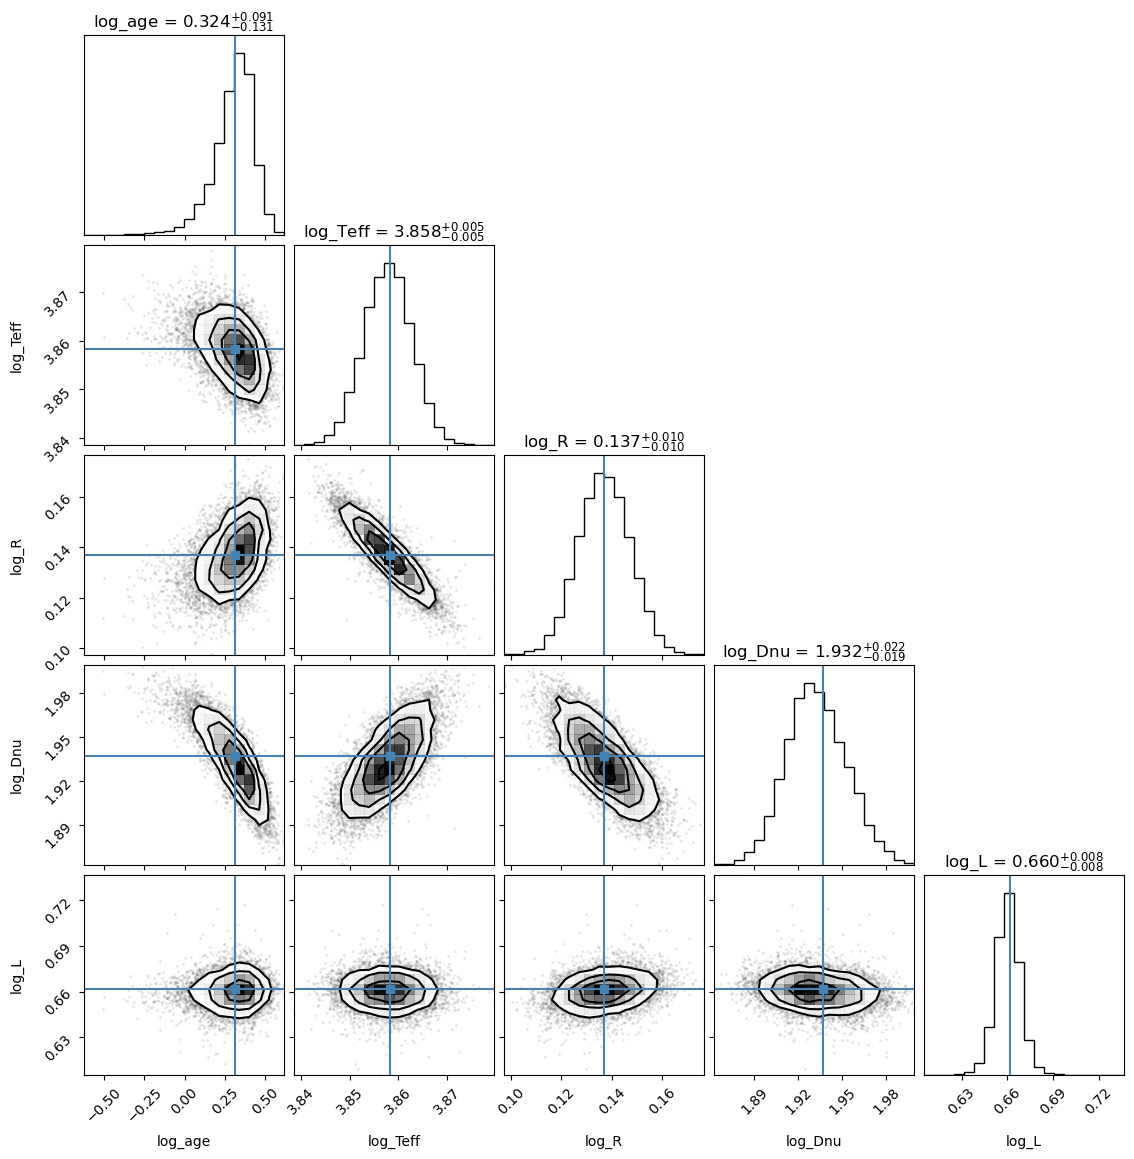

In [26]:
var_names = ["log_age", "log_Teff", "log_R", "log_Dnu", "log_L"]
fig = corner(data, var_names=var_names, truths=truths, show_titles=True, divergences=True, title_fmt=".3f")